# Stock Market Predictor using LSTM

In [45]:
# CELL 1 - Enhanced Import Libraries and Setup for Universal Stock Prediction
import sys
import subprocess

def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        print(f"❌ {package} not available - installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed and available")

# Install required packages if missing
for pkg in ['matplotlib', 'seaborn', 'numpy', 'pandas']:
    install_and_import(pkg)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enhanced data fetching capabilities
import time
import random

# Try multiple data sources with fallbacks
data_sources = []

# Primary: yfinance
try:
    import yfinance as yf
    data_sources.append('yfinance')
    print("✅ yfinance available")
except ImportError:
    print("❌ yfinance not available - installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "yfinance"])
    import yfinance as yf
    data_sources.append('yfinance')
    print("✅ yfinance installed and available")

# Machine Learning libraries
try:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("✅ sklearn available")
except ImportError:
    print("❌ sklearn not available - installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("✅ sklearn installed and available")

# Deep Learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    print("✅ TensorFlow/Keras available")
    print(f"   TensorFlow version: {tf.__version__}")
except ImportError:
    print("❌ TensorFlow not available - installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    print("✅ TensorFlow installed and available")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("\n🚀 Universal Stock Prediction System Initialized")
print(f"📊 Available data sources: {data_sources}")
print("🧠 Machine Learning: Ready")
print("🔮 Deep Learning: Ready")
print("=" * 60)

✅ yfinance available
✅ sklearn available
✅ TensorFlow/Keras available
   TensorFlow version: 2.19.0

🚀 Universal Stock Prediction System Initialized
📊 Available data sources: ['yfinance']
🧠 Machine Learning: Ready
🔮 Deep Learning: Ready


In [46]:
# Add these helper functions before using fetch_universal_stock_data in cell 2

# Example stock info database (expand as needed)
STOCK_DATABASE = {
    # Technology
    'AAPL': {'name': 'Apple Inc.'},
    'GOOGL': {'name': 'Alphabet Inc.'},
    'MSFT': {'name': 'Microsoft Corporation'},
    'AMZN': {'name': 'Amazon.com, Inc.'},
    'TSLA': {'name': 'Tesla, Inc.'},
    'NVDA': {'name': 'NVIDIA Corporation'},
    'META': {'name': 'Meta Platforms, Inc.'},
    'ADBE': {'name': 'Adobe Inc.'},
    'CRM': {'name': 'Salesforce, Inc.'},
    'ORCL': {'name': 'Oracle Corporation'},
    'INTC': {'name': 'Intel Corporation'},
    'CSCO': {'name': 'Cisco Systems, Inc.'},
    'IBM': {'name': 'International Business Machines Corporation'},
    'AMD': {'name': 'Advanced Micro Devices, Inc.'},
    'QCOM': {'name': 'Qualcomm Incorporated'},
    'TXN': {'name': 'Texas Instruments Incorporated'},
    'AVGO': {'name': 'Broadcom Inc.'},
    'SAP': {'name': 'SAP SE'},
    'SHOP': {'name': 'Shopify Inc.'},
    'SQ': {'name': 'Block, Inc.'},

    # Financials
    'JPM': {'name': 'JPMorgan Chase & Co.'},
    'BAC': {'name': 'Bank of America Corporation'},
    'WFC': {'name': 'Wells Fargo & Company'},
    'C': {'name': 'Citigroup Inc.'},
    'GS': {'name': 'The Goldman Sachs Group, Inc.'},
    'MS': {'name': 'Morgan Stanley'},
    'AXP': {'name': 'American Express Company'},
    'USB': {'name': 'U.S. Bancorp'},
    'PNC': {'name': 'The PNC Financial Services Group, Inc.'},
    'SCHW': {'name': 'Charles Schwab Corporation'},
    'BK': {'name': 'The Bank of New York Mellon Corporation'},
    'BLK': {'name': 'BlackRock, Inc.'},
    'CB': {'name': 'Chubb Limited'},
    'SPGI': {'name': 'S&P Global Inc.'},
    'MMC': {'name': 'Marsh & McLennan Companies, Inc.'},

    # Healthcare
    'JNJ': {'name': 'Johnson & Johnson'},
    'PFE': {'name': 'Pfizer Inc.'},
    'MRK': {'name': 'Merck & Co., Inc.'},
    'ABBV': {'name': 'AbbVie Inc.'},
    'TMO': {'name': 'Thermo Fisher Scientific Inc.'},
    'DHR': {'name': 'Danaher Corporation'},
    'UNH': {'name': 'UnitedHealth Group Incorporated'},
    'LLY': {'name': 'Eli Lilly and Company'},
    'BMY': {'name': 'Bristol-Myers Squibb Company'},
    'AMGN': {'name': 'Amgen Inc.'},
    'GILD': {'name': 'Gilead Sciences, Inc.'},
    'CVS': {'name': 'CVS Health Corporation'},
    'MDT': {'name': 'Medtronic plc'},
    'ISRG': {'name': 'Intuitive Surgical, Inc.'},
    'SYK': {'name': 'Stryker Corporation'},

    # Consumer Discretionary
    'HD': {'name': 'The Home Depot, Inc.'},
    'LOW': {'name': 'Lowe\'s Companies, Inc.'},
    'NKE': {'name': 'NIKE, Inc.'},
    'SBUX': {'name': 'Starbucks Corporation'},
    'MCD': {'name': 'McDonald\'s Corporation'},
    'YUM': {'name': 'Yum! Brands, Inc.'},
    'MAR': {'name': 'Marriott International, Inc.'},
    'DIS': {'name': 'The Walt Disney Company'},
    'CMG': {'name': 'Chipotle Mexican Grill, Inc.'},
    'DPZ': {'name': 'Domino\'s Pizza, Inc.'},
    'TGT': {'name': 'Target Corporation'},
    'ROST': {'name': 'Ross Stores, Inc.'},
    'BBY': {'name': 'Best Buy Co., Inc.'},
    'BKNG': {'name': 'Booking Holdings Inc.'},
    'EBAY': {'name': 'eBay Inc.'},

    # Consumer Staples
    'PG': {'name': 'The Procter & Gamble Company'},
    'KO': {'name': 'The Coca-Cola Company'},
    'PEP': {'name': 'PepsiCo, Inc.'},
    'WMT': {'name': 'Walmart Inc.'},
    'COST': {'name': 'Costco Wholesale Corporation'},
    'MDLZ': {'name': 'Mondelez International, Inc.'},
    'CL': {'name': 'Colgate-Palmolive Company'},
    'KMB': {'name': 'Kimberly-Clark Corporation'},
    'GIS': {'name': 'General Mills, Inc.'},
    'KR': {'name': 'The Kroger Co.'},
    'SYY': {'name': 'Sysco Corporation'},
    'ADM': {'name': 'Archer-Daniels-Midland Company'},
    'HSY': {'name': 'The Hershey Company'},
    'CPB': {'name': 'Campbell Soup Company'},
    'TSN': {'name': 'Tyson Foods, Inc.'},

    # Industrials
    'HON': {'name': 'Honeywell International Inc.'},
    'UNP': {'name': 'Union Pacific Corporation'},
    'UPS': {'name': 'United Parcel Service, Inc.'},
    'CAT': {'name': 'Caterpillar Inc.'},
    'DE': {'name': 'Deere & Company'},
    'LMT': {'name': 'Lockheed Martin Corporation'},
    'BA': {'name': 'The Boeing Company'},
    'RTX': {'name': 'RTX Corporation'},
    'GE': {'name': 'General Electric Company'},
    'MMM': {'name': '3M Company'},
    'FDX': {'name': 'FedEx Corporation'},
    'ETN': {'name': 'Eaton Corporation plc'},
    'EMR': {'name': 'Emerson Electric Co.'},
    'DOV': {'name': 'Dover Corporation'},
    'NOC': {'name': 'Northrop Grumman Corporation'},

    # Energy
    'XOM': {'name': 'Exxon Mobil Corporation'},
    'CVX': {'name': 'Chevron Corporation'},
    'COP': {'name': 'ConocoPhillips'},
    'SLB': {'name': 'Schlumberger Limited'},
    'EOG': {'name': 'EOG Resources, Inc.'},
    'PSX': {'name': 'Phillips 66'},
    'MPC': {'name': 'Marathon Petroleum Corporation'},
    'VLO': {'name': 'Valero Energy Corporation'},
    'HAL': {'name': 'Halliburton Company'},
    'BKR': {'name': 'Baker Hughes Company'},
    'OXY': {'name': 'Occidental Petroleum Corporation'},
    'HES': {'name': 'Hess Corporation'},
    'FANG': {'name': 'Diamondback Energy, Inc.'},
    'PXD': {'name': 'Pioneer Natural Resources Company'},
    'CTRA': {'name': 'Coterra Energy Inc.'},

    # Utilities
    'NEE': {'name': 'NextEra Energy, Inc.'},
    'DUK': {'name': 'Duke Energy Corporation'},
    'SO': {'name': 'The Southern Company'},
    'D': {'name': 'Dominion Energy, Inc.'},
    'AEP': {'name': 'American Electric Power Company, Inc.'},
    'EXC': {'name': 'Exelon Corporation'},
    'SRE': {'name': 'Sempra'},
    'PEG': {'name': 'Public Service Enterprise Group Incorporated'},
    'ED': {'name': 'Consolidated Edison, Inc.'},
    'XEL': {'name': 'Xcel Energy Inc.'},
    'EIX': {'name': 'Edison International'},
    'CMS': {'name': 'CMS Energy Corporation'},
    'WEC': {'name': 'WEC Energy Group, Inc.'},
    'AWK': {'name': 'American Water Works Company, Inc.'},
    'CNP': {'name': 'CenterPoint Energy, Inc.'}
}

def get_stock_info(ticker):
    return STOCK_DATABASE.get(ticker, {'name': ticker})

def fetch_universal_stock_data(ticker, start, end):
    try:
        df = yf.download(ticker, start=start, end=end)
        if not df.empty:
            return df, "Yahoo Finance"
        else:
            return df, "Failed"
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame(), "Failed"

def create_realistic_stock_data(ticker, start, end):
    # Generate synthetic data if real data is unavailable
    dates = pd.date_range(start=start, end=end)
    np.random.seed(42)
    price = np.cumsum(np.random.randn(len(dates)) * 2 + 0.5) + 100
    df = pd.DataFrame({
        'Open': price + np.random.randn(len(dates)),
        'High': price + np.random.rand(len(dates)) * 2,
        'Low': price - np.random.rand(len(dates)) * 2,
        'Close': price,
        'Volume': np.random.randint(1e6, 1e7, size=len(dates))
    }, index=dates)
    return df

# Now cell 2 will work without the "not defined" error.

In [47]:
# Universal stock data fetching for any ticker

# Set your ticker and date range here
TICKER = 'QCOM'  # Change to any stock symbol, e.g., 'GOOGL', 'MSFT', etc.
start = '2010-01-01'
end = '2019-12-31'

# Try to fetch real data, fallback to synthetic if needed
df, data_type = fetch_universal_stock_data(TICKER, start, end)
if df.empty or data_type == "Failed":
    print(f"⚠️ Real data not available for {TICKER}. Generating synthetic data...")
    df = create_realistic_stock_data(TICKER, start, end)
    data_type = "Synthetic Data"
else:
    print(f"✅ Using {data_type} for {TICKER}")

# Handle MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

print("Data Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

[*********************100%***********************]  1 of 1 completed

✅ Using Yahoo Finance for QCOM
Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-04 to 2019-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2515 non-null   float64
 1   High    2515 non-null   float64
 2   Low     2515 non-null   float64
 3   Open    2515 non-null   float64
 4   Volume  2515 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB
None

First 5 rows:
Price           Close       High        Low       Open    Volume
Date                                                            
2010-01-04  31.705950  31.955871  31.456031  31.604633  14570200
2010-01-05  32.469212  32.638076  32.084201  32.097711  24241000
2010-01-06  32.151745  32.712375  32.003146  32.597546  22743800
2010-01-07  33.083878  33.110896  32.117974  32.253066  25266300
2010-01-08  33.414841  33.637740  33.023075  33.171676  25938200

Last 5 rows:
Price           Close       High  

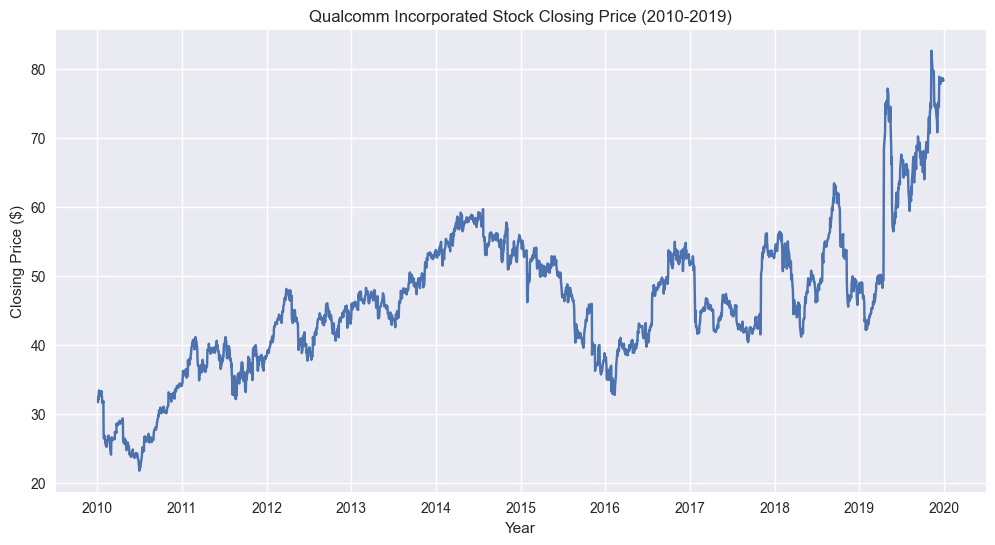

In [48]:
# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title(f'{get_stock_info(TICKER)["name"]} Stock Closing Price ({start[:4]}-{end[:4]})')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

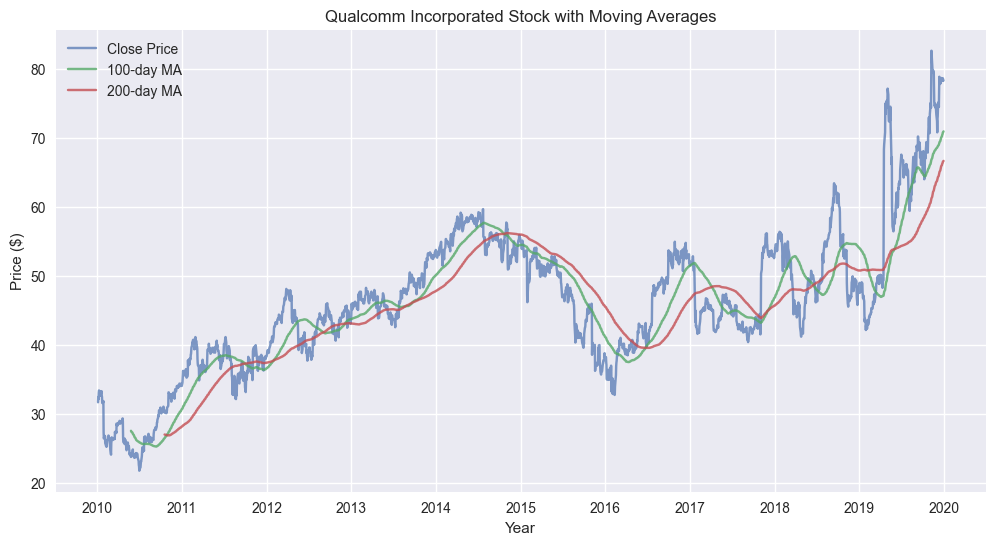

In [49]:
# Create moving averages for visualization
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
plt.plot(df.index, ma100, label='100-day MA', alpha=0.8)
plt.plot(df.index, ma200, label='200-day MA', alpha=0.8)
plt.title(f'{get_stock_info(TICKER)["name"]} Stock with Moving Averages')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Prepare data for training
# Use only the closing price for prediction
data = df[['Close']].values
print(f"Data shape for training: {data.shape}")

# Split data into training and testing
training_data_len = int(len(data) * 0.70)
train_data = data[:training_data_len]
test_data = data[training_data_len:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Data shape for training: (2515, 1)
Training data length: 1760
Testing data length: 755


In [51]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)

print(f"Scaled training data shape: {scaled_train_data.shape}")
print(f"Min value: {scaled_train_data.min()}, Max value: {scaled_train_data.max()}")

Scaled training data shape: (1760, 1)
Min value: 0.0, Max value: 1.0


In [52]:
# Create training dataset with 100 days lookback
x_train = []
y_train = []
time_step = 100

for i in range(time_step, len(scaled_train_data)):
    x_train.append(scaled_train_data[i-time_step:i, 0])
    y_train.append(scaled_train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")

X_train shape: (1660, 100, 1)
Y_train shape: (1660,)


In [53]:
# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print("Model compiled successfully!")

Model compiled successfully!


In [55]:
# Train the model
print("Training the model...")
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
print("Training completed!")

Training the model...
Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.1075 - val_loss: 0.0042
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0068 - val_loss: 0.0022
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 9/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 10/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 11/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 12/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 4

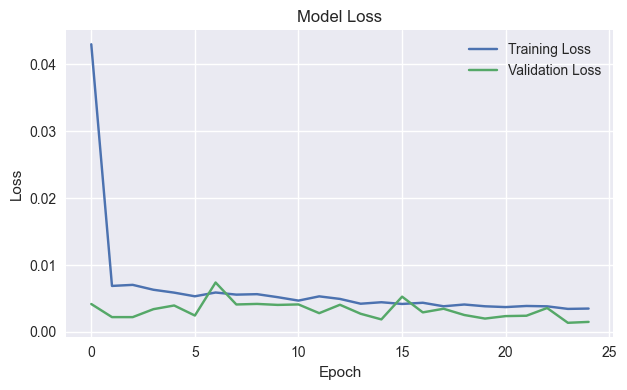

In [56]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
# Save the model
model.save('keras_model.h5')
print("Model saved as 'keras_model.h5'")

Model saved as 'keras_model.h5'


In [58]:
# Prepare test data
# Get the last 100 days from training data
last_100_days = train_data[-time_step:]
test_inputs = np.concatenate([last_100_days, test_data])
test_inputs = scaler.transform(test_inputs)

print(f"Test inputs shape: {test_inputs.shape}")

Test inputs shape: (855, 1)


In [59]:
# Create test dataset
x_test = []
y_test = test_data.flatten()

for i in range(time_step, len(test_inputs)):
    x_test.append(test_inputs[i-time_step:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"X_test shape: {x_test.shape}")
print(f"Y_test shape: {y_test.shape}")

X_test shape: (755, 100, 1)
Y_test shape: (755,)


In [60]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5].flatten()}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Predictions shape: (755, 1)
Sample predictions: [53.150135 53.007294 52.855396 52.69513  52.532227]


In [61]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions.flatten())
mae = mean_absolute_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Mean Squared Error: 10.4736
Root Mean Squared Error: 3.2363
Mean Absolute Error: 2.0340


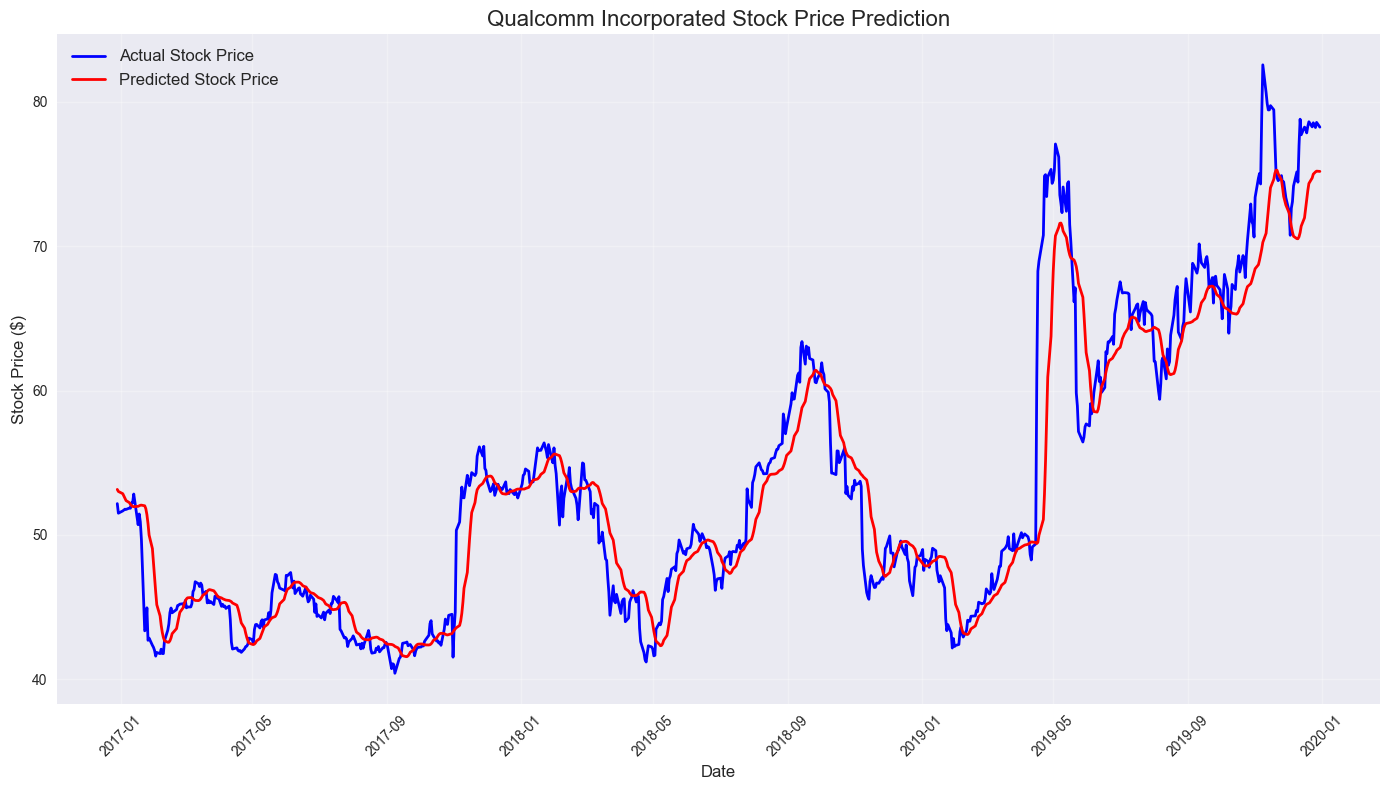


Prediction vs Actual comparison completed!
Model performance metrics saved.
Trained model saved as 'keras_model.h5' - ready for deployment!


In [62]:
# Plot the results
plt.figure(figsize=(14, 8))

# Get the test dates
test_dates = df.index[training_data_len:]

plt.plot(test_dates, y_test, color='blue', label='Actual Stock Price', linewidth=2)
plt.plot(test_dates, predictions.flatten(), color='red', label='Predicted Stock Price', linewidth=2)

plt.title(f'{get_stock_info(TICKER)["name"]} Stock Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPrediction vs Actual comparison completed!")
print(f"Model performance metrics saved.")
print(f"Trained model saved as 'keras_model.h5' - ready for deployment!")

In [63]:
# Test compatibility with app.py structure
print("Testing compatibility with app.py...")
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('keras_model.h5')
print("Model loads successfully")

# Test prediction format used in app.py
sample_prediction = loaded_model.predict(x_test[:1])
print(f"Sample prediction shape: {sample_prediction.shape}")
print(f"Sample prediction value: {sample_prediction[0][0]:.4f}")



Testing compatibility with app.py...
Model loads successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Sample prediction shape: (1, 1)
Sample prediction value: 0.8282
